# PPE tower analysis
- Daniel Kennedy (djk2120@ucar.edu)
- updated March 25, 2022

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm
import os

### optional: set up your PBSCluster
- not necessary if you are working with preprocessed data
- client.cluster will show when your workers are active
- note it can take a few minutes to get through the job queue
- set up to ask for 3hrs, but can be increased

In [2]:
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

In [3]:
## wait until workers >0
client.cluster

In [4]:
topdir = '/glade/scratch/djk2120/PPEn11/hist/amflx/'
files = sorted(glob.glob(topdir+'*.nc'))[1:]
lhckey = '/glade/scratch/djk2120/PPEn11/amflx_lhc/lhc_220331.txt'
df = pd.read_csv(lhckey)

In [5]:
def preprocess(ds,singles=False):
    datavars = ['FPSN','EFLX_LH_TOT','VEGWP','SOILWATER_10CM','TWS','BTRAN','H2OSOI','TV','FSA'
               ,'FCTR','FGEV','FCEV']
    onecopy  = ['RAIN','SNOW','FSDS','mcsec','TLAI']
    nt = len(ds.time)
    ix = np.arange(nt)<nt-1 #first timestep is not meaningful
    if singles:
        ds2 = ds[onecopy].shift(time=-1).isel(time=ix,lndgrid=0)
    else:
        ds2 = ds[datavars].shift(time=-1).isel(time=ix,lndgrid=0)
    return ds2

In [40]:
ds0 = preprocess(xr.open_dataset(files[0]),singles=True)
ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                       parallel=True,preprocess=preprocess,chunks={'time':14612})
for dv in ds0.data_vars:
    ds[dv]=ds0[dv]

In [7]:
ds

<xarray.Dataset>
Dimensions:         (ens: 250, time: 175344, nvegwcs: 4, levsoi: 20)
Coordinates:
  * levsoi          (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time            (time) datetime64[ns] 2008-01-01 ... 2017-12-31T23:30:07....
Dimensions without coordinates: ens, nvegwcs
Data variables: (12/17)
    FPSN            (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    EFLX_LH_TOT     (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    VEGWP           (ens, time, nvegwcs) float32 dask.array<chunksize=(1, 14612, 4), meta=np.ndarray>
    SOILWATER_10CM  (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    TWS             (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    BTRAN           (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    ...              ...
    FCEV            (ens, time) float32 dask.array<chunksize=(1, 14612), meta=np.ndarray>
    RAIN            (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SNOW            (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FSDS            (time) float32 0.0 0.0 0.0 0.0 ... 259.1 139.9 85.37 31.55
    mcsec           (time) float64 1.8e+03 3.6e+03 5.4e+03 ... 8.46e+04 0.0
    TLAI            (time) float32 0.5643 0.5643 0.5643 ... 0.5644 0.5643 0.5643
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 03/31/22 16:32:56
    source:                                    Community Terrestrial Systems ...
    hostname:                                  casper
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          minute_30

In [11]:
ds.FPSN

<xarray.DataArray 'FPSN' (ens: 250, time: 175344)>
dask.array<concatenate, shape=(250, 175344), dtype=float32, chunksize=(1, 14612), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2017-12-31T23:30:07.031249984
Dimensions without coordinates: ens
Attributes:
    long_name:     photosynthesis
    units:         umol m-2 s-1
    cell_methods:  time: mean

In [8]:
def plotter(da,df):
    plt.figure(figsize=[18,12])
    for i,p in enumerate(df.columns[1:]):
        plt.subplot(4,6,i+1)
        plt.plot(df[p],da,'.')
        if i%6==0:
            plt.ylabel(da.name)
        if i==20:
            plt.xlabel('quantile within parameter range')
        plt.title(p)

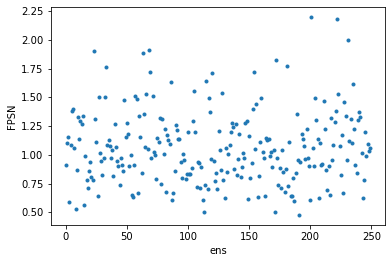

In [10]:
v = 'FPSN'
x = ds[v].mean(dim='time').compute()
x.plot.line('.')

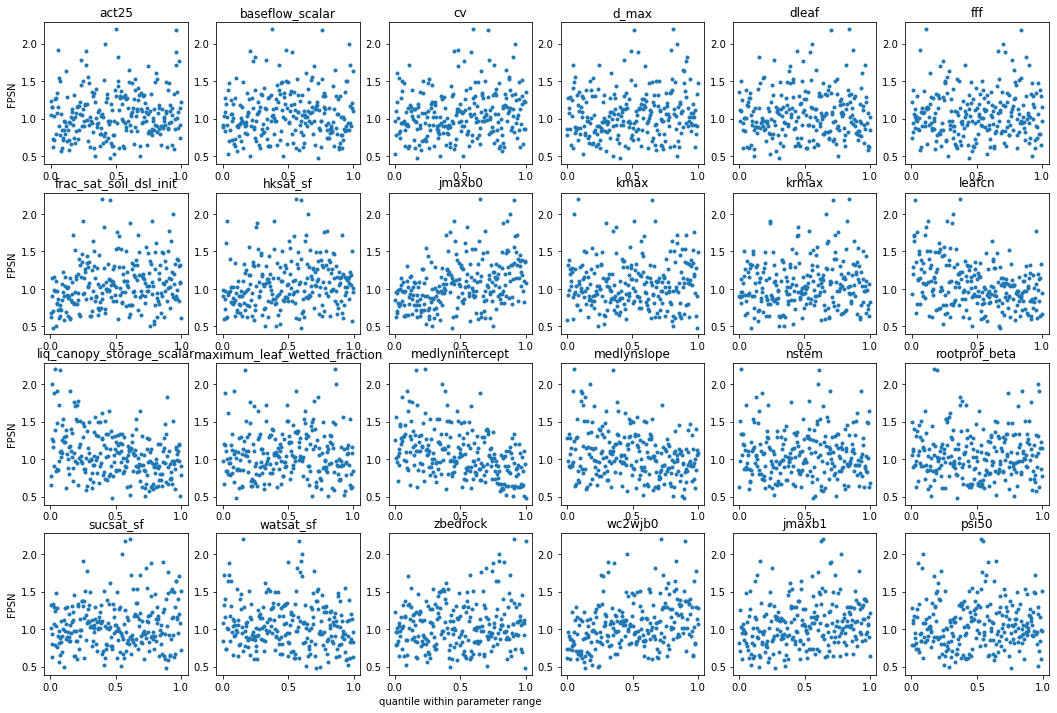

In [15]:
plotter(x,df)

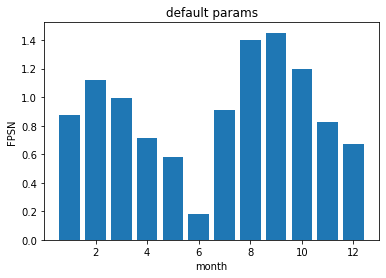

In [46]:
seas = ds.FPSN.isel(ens=0).groupby('time.month').mean().compute()
plt.bar(1+np.arange(12),seas)
plt.xlabel('month')
plt.ylabel('FPSN')
plt.title('default params');

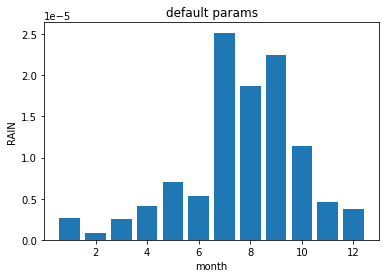

In [48]:
seas = ds.RAIN.groupby('time.month').mean().compute()
plt.bar(1+np.arange(12),seas)
plt.xlabel('month')
plt.ylabel('RAIN')
plt.title('default params');

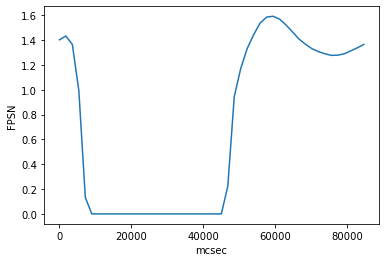

In [42]:
ixm = ds['time.month']==4
g = ds.mcsec
diurn = ds.FPSN.isel(time=ixm,ens=0).groupby(g[ixm]).mean().compute()
diurn.plot();